Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from skimage import transform
import numpy as np
import pywt
from torch.utils.data import Dataset
import PIL.Image as Image
from math import exp
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

WaveMixSR

In [2]:
class Level1Waveblock(nn.Module):
    def __init__(self, c):
        super(Level1Waveblock, self).__init__()
        self.conv = nn.Conv2d(c, c // 4, 3,padding = 1)
        self.feedforward = nn.Sequential(
            nn.Conv2d(c, c, 1),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Conv2d(c, c, 1),
            nn.ConvTranspose2d( c, c, 4, stride=2, padding=1),
            nn.BatchNorm2d(c)
        )

    def haar_wavelet_transform(self, x):
        batch_size, coefficients = x.size(0), []

        for i in range(batch_size):
            image = x[i]
            image_np = image.detach().cpu().numpy()
            image_coefficients = []

            for channel in image_np:
                aa,(ad,da,dd) = pywt.dwt2(channel, 'haar')
                image_coefficients.append(aa)
                image_coefficients.append(ad)
                image_coefficients.append(da)
                image_coefficients.append(dd)

            coefficients.append(image_coefficients)

        return torch.tensor(np.array(coefficients)).to(device)

    def forward(self, x):
        x = self.conv(x)
        x = self.haar_wavelet_transform(x)
        x = self.feedforward(x)
        return x.to(device)

In [3]:
import torch.nn as nn
import torchvision.models as models

class WaveMixSR(nn.Module):
    def __init__(self, depth, c):
        super(WaveMixSR, self).__init__()
        resnet18 = models.resnet18().to(device)
        
        # Load the pre-trained weights from the given path
        pre_trained_weights = torch.load("/kaggle/input/resnet18/resnet18-f37072fd.pth")
        resnet18.load_state_dict(pre_trained_weights)

        # Get the first three layers from VGG11
        self.resnet_layers = nn.Sequential(
            resnet18.conv1,   # First convolutional layer
            resnet18.bn1,     # Batch normalization layer
            resnet18.relu,    # ReLU activation function
            resnet18.maxpool,  # Max pooling layer
            resnet18.layer1,  # The first residual block
            resnet18.layer2  # The second residual block
        ).to(device)

        # WaveMixSR layers
        self.layers = nn.ModuleList([Level1Waveblock(c) for _ in range(depth)])

        self.final = nn.Sequential(
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.Conv2d(8, 3, 3, stride=1, padding=1),
        )

        # Use VGG11's initial layers in self.path1
        self.path1 = nn.Sequential(
            nn.Upsample(scale_factor=7, mode='bicubic', align_corners=False),
            self.resnet_layers,  # Use VGG11's first three layers
        )

    def forward(self, img):
        
        y = self.path1(img)
        
        # Apply WaveMixSR layers
        for layer in self.layers:
            y = layer(y) + y
            
        
        # Final transformation to convert back to 1-channel
        y = self.final(y)
        
        resize_transform = transforms.Resize((128, 128))

        # Apply the transformation
        img_resized = resize_transform(y)

        # Concatenate the Y and CrCb components
        return img_resized.to(device)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7  = nn.Linear(16,1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = torch.sigmoid(x)
        return x.to(device)

Loss

In [5]:
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(torch.sqrt(torch.abs(torch.max(img1)))/ torch.sqrt(mse)).to(device)

class PSNRLoss(torch.nn.Module):
    def __init__(self):
        super(PSNRLoss, self).__init__()

    def forward(self, img1, img2):
        return -psnr(img1, img2)

In [6]:
class EntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, disc_output, labels):
        return F.binary_cross_entropy(disc_output, labels)

Dataset

In [7]:
from keras.datasets import mnist
from keras.utils import to_categorical
from PIL import Image

class SuperResolutionDataset(Dataset):
    def __init__(self, dataset, upscale_factor):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]
        img_pil = Image.fromarray(img.astype('uint8'))
        img_ycbcr = img_pil.convert('YCbCr')
        lr_img = self.transform(img_ycbcr)
        hr_img = transforms.ToTensor()(img_ycbcr)

        return lr_img, hr_img


import os
from sklearn.model_selection import train_test_split

image_dir = '/kaggle/input/dataset/flowers/flowers'
image_files = np.array([Image.open(os.path.join(image_dir, file)) for file in os.listdir(image_dir)])
train_X, test_X = train_test_split(image_files, test_size=0.2, random_state=42)

upscale_factor = 2

train_dataset = SuperResolutionDataset(train_X, upscale_factor)
test_dataset = SuperResolutionDataset(test_X, upscale_factor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

2024-04-26 19:28:52.308572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 19:28:52.308672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 19:28:52.441009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Models

In [13]:
generator = WaveMixSR(depth=4, c=128).to(device)
discriminator = Discriminator().to(device)

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
dis_optimizer = torch.optim.Adam(discriminator.parameters(),lr=0.001)

gen_loss_function = PSNRLoss()
dis_loss_function = EntropyLoss()

Training

In [14]:
num_epochs = 10
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    
    running_gen_loss = 0.0
    running_dis_floss = 0.0
    running_dis_tloss = 0.0
    
    for inputs, targets in train_loader:
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        
        #Generator Output
        outputs = generator(inputs.to(device))
        
        #Descriminator Output
        f_labels = discriminator(outputs)
        t_labels = discriminator(targets.to(device))        
        
        #Discriminator Loss & Back Prop
        dis_floss = dis_loss_function(f_labels,torch.zeros_like(f_labels,dtype=torch.float))
        dis_tloss = dis_loss_function(t_labels,torch. ones_like(t_labels,dtype=torch.float))
        
        dis_floss.backward(retain_graph=True)
        dis_tloss.backward()
        
        dis_optimizer.step()
        
        #Generator Loss Calculation & Back Prop
        gen_loss = gen_loss_function(outputs,targets.to(device))
        gen_loss.backward()
        gen_optimizer.step()
        
        running_dis_floss += dis_floss.item() * inputs.size(0)
        running_dis_tloss += dis_tloss.item() * inputs.size(0)
        running_gen_loss  += gen_loss.item()  * inputs.size(0)
        
    epoch_gen_loss  = running_gen_loss  / len(train_loader.dataset)
    epoch_dis_floss = running_dis_floss / len(train_loader.dataset)
    epoch_dis_tloss = running_dis_tloss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Gen Loss: {epoch_gen_loss} , Dis_floss : {epoch_dis_floss}, Dis_tloss : {epoch_dis_tloss}")

Epoch 1/10, Gen Loss: -19.982967044307976 , Dis_floss : 0.1757226737990929, Dis_tloss : 0.1725750275914811
Epoch 2/10, Gen Loss: -26.7498553659906 , Dis_floss : 0.019261043997243803, Dis_tloss : 0.013744968310931797
Epoch 3/10, Gen Loss: -28.340870663338183 , Dis_floss : 0.01817285021821058, Dis_tloss : 0.018347320465174292
Epoch 4/10, Gen Loss: -29.1532521228078 , Dis_floss : 0.006408777932015551, Dis_tloss : 0.006680801320730233
Epoch 5/10, Gen Loss: -29.57579725906562 , Dis_floss : 0.006556283960385487, Dis_tloss : 0.004889699480399073
Epoch 6/10, Gen Loss: -29.99158853712913 , Dis_floss : 0.0011899899538150589, Dis_tloss : 0.0004164262071752967
Epoch 7/10, Gen Loss: -31.512025476985947 , Dis_floss : 0.00242027941192031, Dis_tloss : 0.0011022831251873988
Epoch 8/10, Gen Loss: -33.600033122968874 , Dis_floss : 0.005122004642861475, Dis_tloss : 0.002003425627207314
Epoch 9/10, Gen Loss: -33.822778108209 , Dis_floss : 0.09643087296842968, Dis_tloss : 0.05252189807561967
Epoch 10/10, Ge

Testing

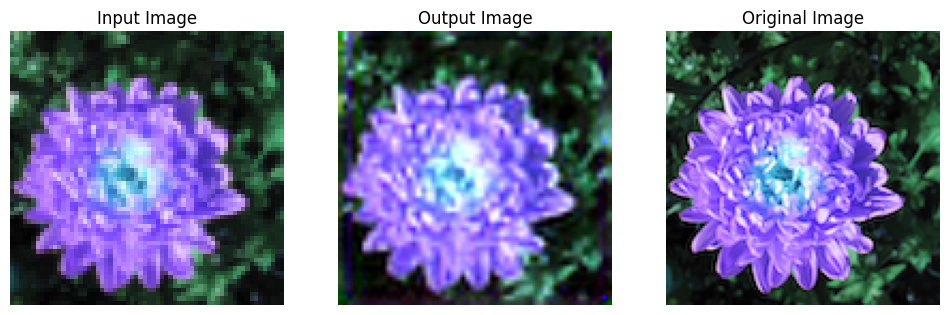

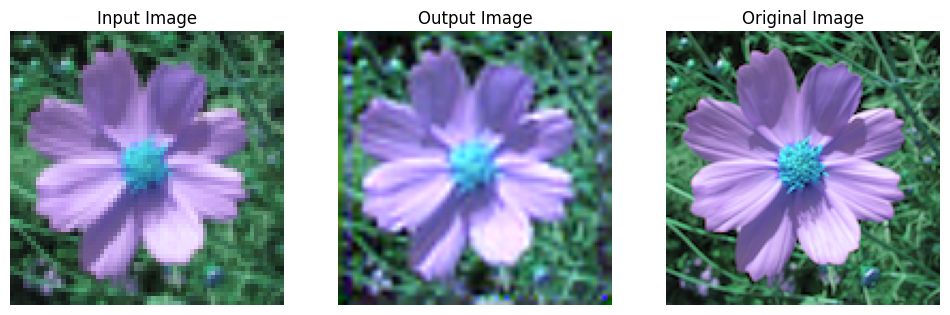

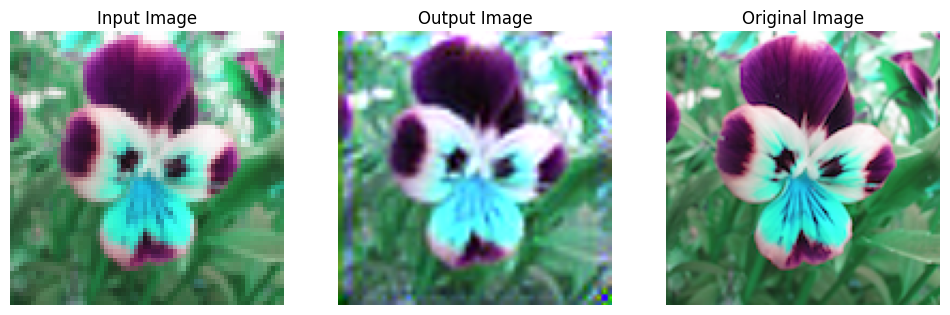

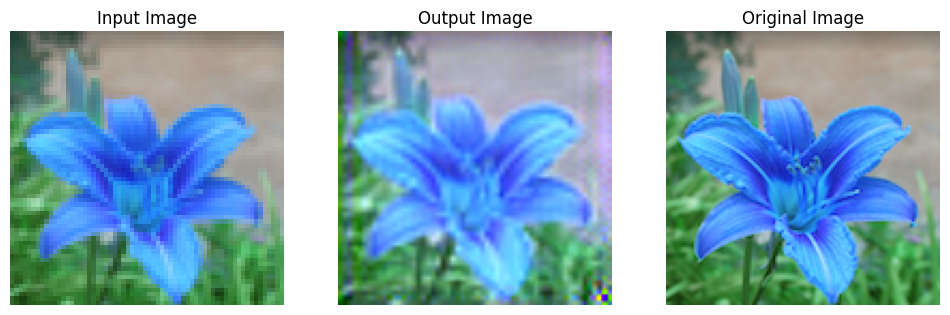

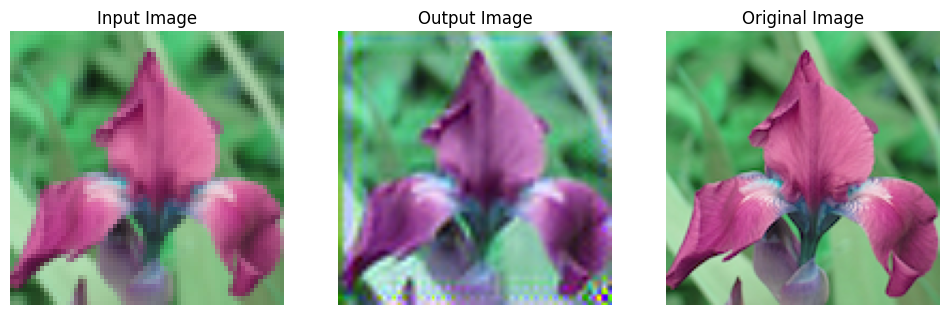

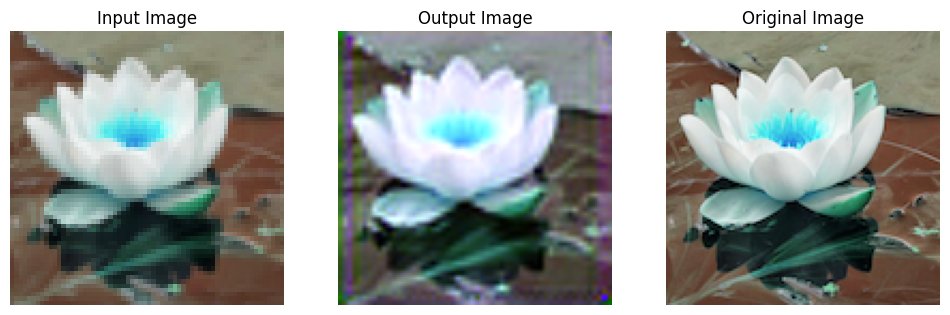

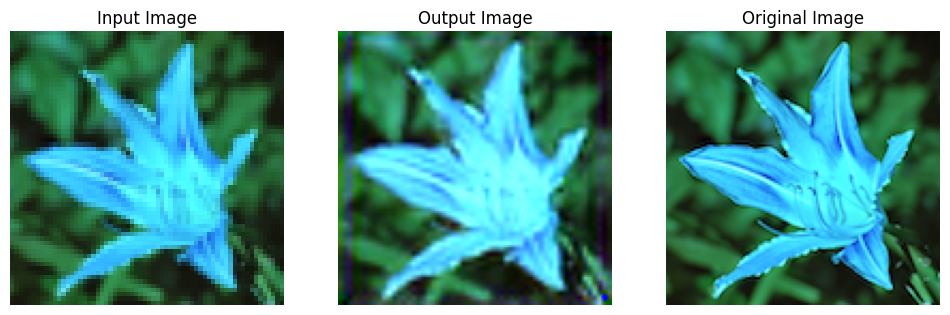

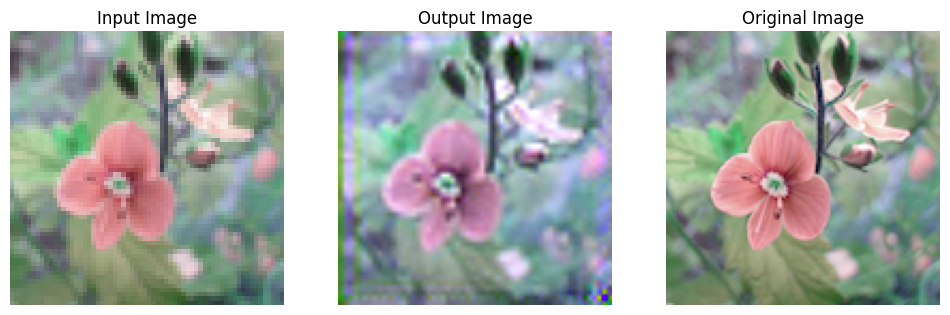

Average PSNR on test set: 34.97074890136719


In [15]:
import matplotlib.pyplot as plt
import cv2

generator.eval()
total_psnr = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = generator(inputs.to(device))
        psnr_value = psnr(outputs, targets.to(device))
        total_psnr += psnr_value.item()

        input_image = inputs[3].permute(1, 2, 0).cpu().numpy()
        output_image = outputs[3].permute(1, 2, 0).cpu().numpy()
        target_image = targets[3].permute(1, 2, 0).cpu().numpy()

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.show()

average_psnr = total_psnr / len(test_loader)
print(f"Average PSNR on test set: {average_psnr}")